In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from natsort import natsorted
import xarray as xr

import matplotlib.pyplot as plt
import sunpy.visualization.colormaps as cm
from codecarbon import track_emissions

The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]


In [2]:
data_path = "../../../all128.nc"
ds = xr.open_dataset(data_path)
print(f"{ds.channel=}")

selected_channel = ds['DN'].sel(channel='171A')
print(f"{selected_channel=}")

img = selected_channel.isel(time=0)
cmap = plt.get_cmap('sdoaia171')
img.plot(cmap=cmap)
plt.savefig("single.png")
plt.close()

keys = natsorted(ds['channel'].data)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for ax, key in zip(axes.ravel(), keys):
    data = ds['DN'].sel(channel=key).isel(time=0)
    cmap = plt.get_cmap(f'sdoaia{key[:-1]}')
    im = data.plot(cmap=cmap, ax=ax, add_colorbar=False)
    ax.set_title(key)
    ax.axis('off')

plt.savefig("multiple.png")
plt.close()

ds.channel=<xarray.DataArray 'channel' (channel: 9)> Size: 72B
array(['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A'],
      dtype=object)
Coordinates:
  * channel  (channel) object 72B '131A' '1600A' '1700A' ... '304A' '335A' '94A'
selected_channel=<xarray.DataArray 'DN' (time: 6130, x: 128, y: 128)> Size: 402MB
[100433920 values with dtype=float32]
Coordinates:
  * time     (time) int32 25kB 0 1 2 3 4 5 6 ... 6124 6125 6126 6127 6128 6129
  * x        (x) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
  * y        (y) int32 512B 0 1 2 3 4 5 6 7 ... 120 121 122 123 124 125 126 127
    channel  <U4 16B '171A'


In [3]:
ds["DN"].sel(channel='171A').values.shape

(6130, 128, 128)

<Figure size 640x480 with 0 Axes>

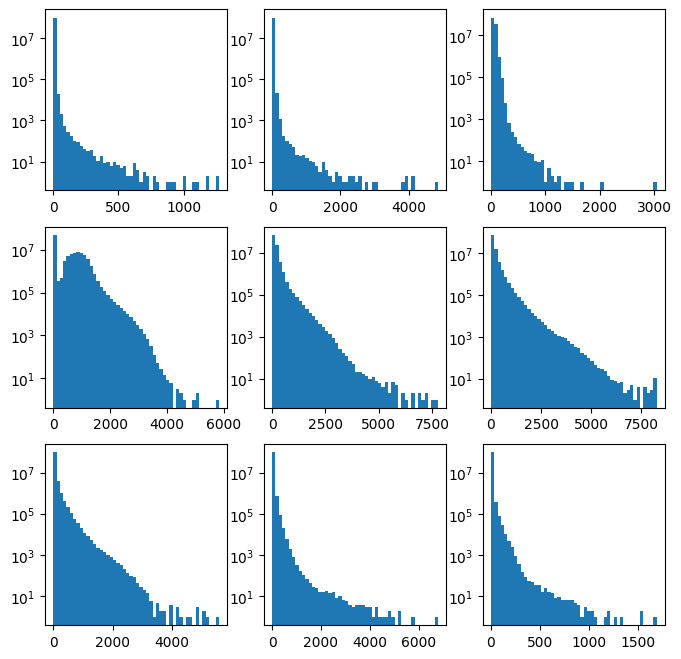

In [4]:
# plot distribution of pixel intensity for each channel
channels = ['94A', '131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A']

plt.clf()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.hist(ds["DN"].sel(channel=channels[i]).values.flatten(), bins=50)
    ax.set_yscale('log')
plt.show()

In [5]:
# NFs = [500, 1800, 1000, 5000, 6000, 7000, 3500, 4000, 1000] # eye balled these
# # for each channel normalize the pixels
# for NF, ch in zip(NFs, channels):
#     print(NF, ch)
#     ds["DN"].loc[dict(channel=ch)] = ds["DN"].sel(channel=ch)/NF

# plt.clf()
# fig, axes = plt.subplots(3, 3, figsize=(8, 8))
# for i, ax in enumerate(axes.ravel()):
#     ax.hist(ds["DN"].sel(channel=channels[i]).values.flatten(), bins=50)
#     ax.set_yscale('log')
# plt.show()

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import xarray as xr
import numpy as np

QUADRATE = True

def stack_channels(ds):
    channels = ['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A']
    data_list = []
    for ch in channels:
        da = ds.sel(channel=ch)['DN']  # shape: (time, x, y)
        data_list.append(da.values)    # (time, x, y)
    data_array = np.stack(data_list, axis=1)  # shape: (time, channel, x, y)
    return data_array

full_data = stack_channels(ds)  # shape: (6130, 9, 128, 128)

if QUADRATE:
    # Input: Channel 94A (index 8)
    # Output:  Channels (indices 0–7)
    inputs_1 = full_data[:, 8, :64, :64]         # shape: (6130, 128, 128)
    targets_1 = full_data[:, 0:8, :64, :64]      # shape: (6130, 8, 128, 128)
    inputs_2 = np.rot90(full_data[:, 8, 64:, 64:], k=2, axes=(1, 2))         # shape: (6130, 128, 128)
    targets_2 = np.rot90(full_data[:, 0:8, 64:, 64:], k=2, axes=(2, 3))      # shape: (6130, 8, 128, 128)
    inputs_3 = np.rot90(full_data[:, 8, 64:, :64], k=3, axes=(1, 2))         # shape: (6130, 128, 128)
    targets_3 = np.rot90(full_data[:, 0:8, 64:, :64], k=3, axes=(2, 3))      # shape: (6130, 8, 128, 128)
    inputs_4 = np.rot90(full_data[:, 8, :64, 64:], k=1, axes=(1, 2))         # shape: (6130, 128, 128)
    targets_4 = np.rot90(full_data[:, 0:8, :64, 64:], k=1, axes=(2, 3))      # shape: (6130, 8, 128, 128)

    inputs = np.concatenate([inputs_1, inputs_2, inputs_3, inputs_4], axis=0)
    targets = np.concatenate([targets_1, targets_2, targets_3, targets_4], axis=0)
else:
    inputs = full_data[:, 8, :, :]
    targets = full_data[:, 0:8, :, :]

# convert to torch
inputs_tensor = torch.from_numpy(inputs).float()
targets_tensor = torch.from_numpy(targets).float()

# Dataset-class
class ChannelPredictionDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs.unsqueeze(1)  # shape: (N, 1, 128, 128)
        self.targets = targets             # shape: (N, 8, 128, 128)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# create dataset
full_dataset = ChannelPredictionDataset(inputs_tensor, targets_tensor)

# Training/Test split (80% / 20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from codecarbon import track_emissions

class ChannelPredictorCNN(nn.Module):

    channels = ['131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A', '94A']
    NFs = [50, 100, 300, 2500, 2500, 2500, 1500, 1000, 200] # eye balled these
    def __init__(self):
        super(ChannelPredictorCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B, 64, 128, 128)
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # (B, 32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 8, kernel_size=3, padding=1)    # (B, 8, 128, 128)
        )

    def forward(self, x):
        # normalize the channels using the NFs
        x = x/self.NFs[-1]
        x = self.encoder(x)
        x = self.decoder(x)

        # loop through channels in x
        for i, channel in enumerate(self.channels[:-1]):
            x[:, i, :, :] *= self.NFs[i]
        return x


In [8]:
import torch
import torch.optim as optim

# Modell, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChannelPredictorCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

# Training
@track_emissions(project_name="sunny_days", log_level="error", tracking_mode="process")
def train_model(model, train_loader, test_loader, epochs=10):
    # channel_weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    # channel_weights = channel_weights / sum(channel_weights)
    # channel_weights = torch.tensor(channel_weights).to(device)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss =  criterion(outputs, targets)
            # loss = sum(channel_weights[i] * criterion(outputs[:, i, :, :], targets[:, i, :, :]) for i in range(outputs.shape[1]))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_losses.append(train_loss/len(train_loader))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

        # Optional: Evaluate on test set
        val_losses.append(evaluate_model(model, test_loader))
    return train_losses, val_losses

def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"  ➤ Test Loss: {total_loss/len(test_loader):.4f}")
    return total_loss/len(test_loader)


In [9]:
train_loss, val_loss = train_model(model, train_loader, test_loader, epochs=7)


[codecarbon WARNING @ 10:37:58] Multiple instances of codecarbon are allowed to run at the same time.


Epoch 1/7, Loss: 22959.7662
  ➤ Test Loss: 11687.5313
Epoch 2/7, Loss: 10254.3664
  ➤ Test Loss: 9303.2855
Epoch 3/7, Loss: 8830.8513
  ➤ Test Loss: 8587.1676
Epoch 4/7, Loss: 8079.0286
  ➤ Test Loss: 7781.3625
Epoch 5/7, Loss: 7484.7819
  ➤ Test Loss: 7625.8666
Epoch 6/7, Loss: 6934.7339
  ➤ Test Loss: 6847.2250
Epoch 7/7, Loss: 6507.5317
  ➤ Test Loss: 6311.6562


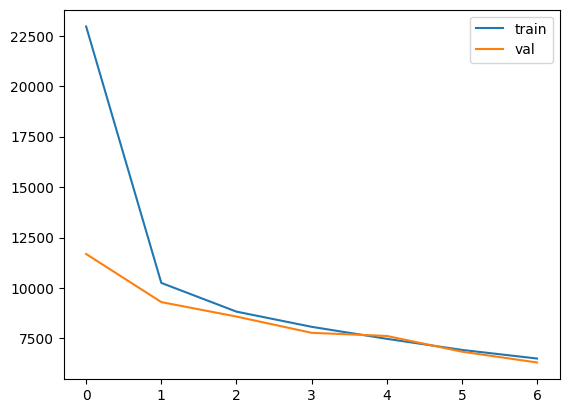

In [10]:
plt.clf()
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.show()

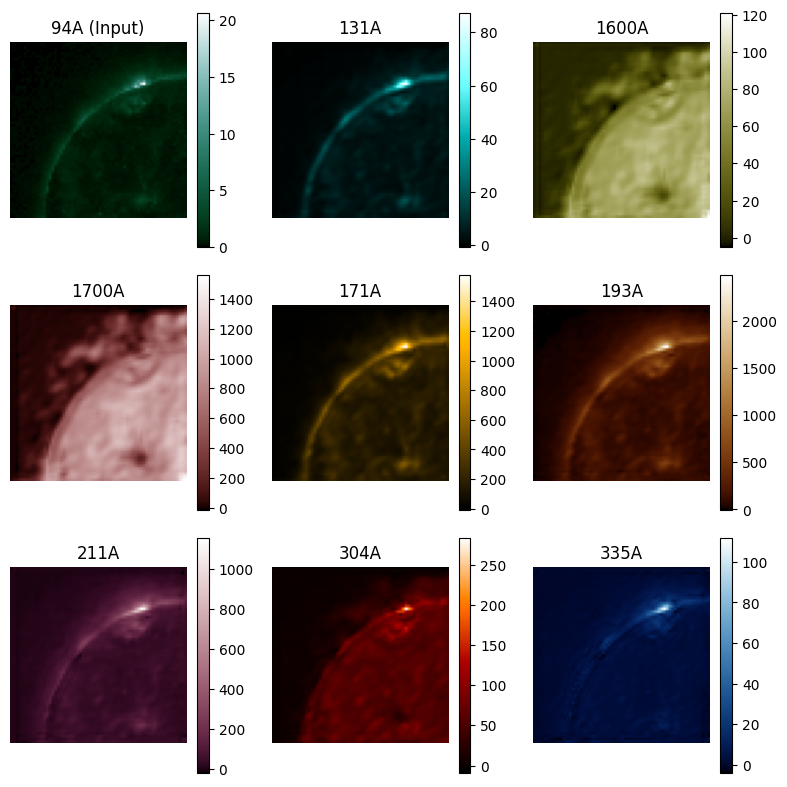

In [11]:
test_index = -1
COLORBAR = True
import matplotlib.pyplot as plt
model.eval()

input_img, target_img = test_dataset[test_index]  # input: (1, 128, 128), target: (8, 128, 128)
input_img = input_img.unsqueeze(0).to(device)  # (1, 1, 128, 128)

with torch.no_grad():
    predicted = model(input_img).cpu().squeeze(0)  # (8, 128, 128)

input_np = input_img.cpu().squeeze(0).squeeze(0).numpy()  # (128, 128)
pred_np = predicted.numpy()  # (8, 128, 128)
target_np = target_img.numpy()

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
channels = ['94A (Input)', '131A', '1600A', '1700A', '171A', '193A', '211A', '304A', '335A']

for i, (ax, ch) in enumerate(zip(axes.ravel(), channels)):
    if ch == '94A (Input)':
        cmap = plt.get_cmap('sdoaia94')
        im = ax.imshow(input_np, cmap=cmap)
    else:
        cmap = plt.get_cmap(f'sdoaia{ch[:-1]}')
        im = ax.imshow(pred_np[i-1], cmap=cmap)
    
    ax.set_title(ch)
    ax.axis('off')
    if COLORBAR: fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8444\31815815.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 10 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  if COLORBAR: fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_8444\31815815.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 11 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  if COLORBAR: fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_8444\31815815.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 12 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is called on.
  if COLORBAR: fig.colorbar(im, ax=ax)
C:\Users\USER\AppData\Local\Temp\ipykernel_8444\31815815.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 13 Axes> than <Figure size 800x800 with 18 Axes> which fig.colorbar is ca

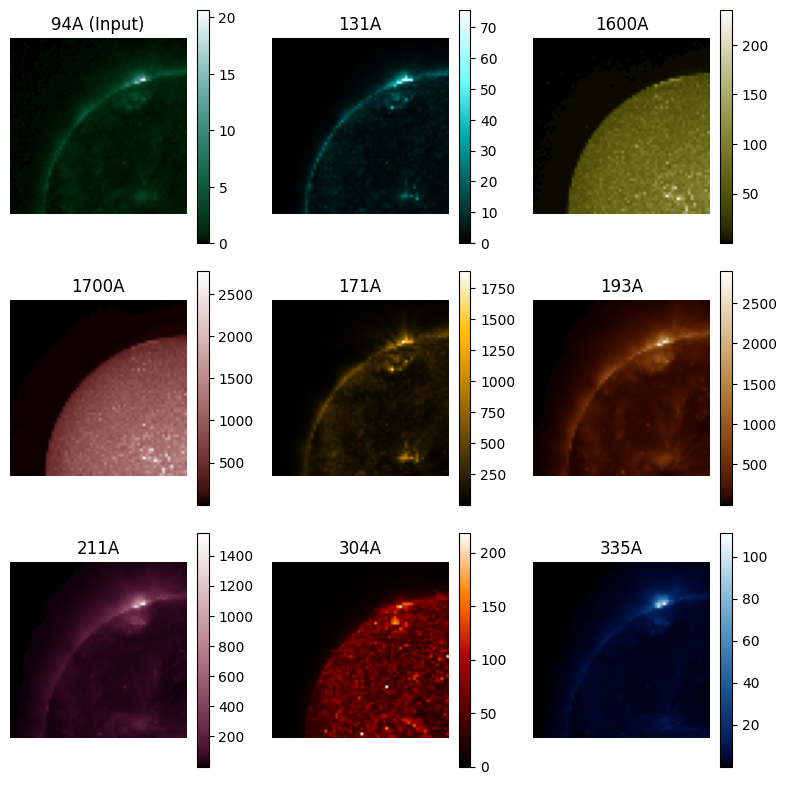

In [12]:
fig_2, axes_2 = plt.subplots(3, 3, figsize=(8, 8))
for i, (ax, ch) in enumerate(zip(axes_2.ravel(), channels)):
    if ch == '94A (Input)':
        cmap = plt.get_cmap('sdoaia94')
        im = ax.imshow(input_np, cmap=cmap)
    else:
        cmap = plt.get_cmap(f'sdoaia{ch[:-1]}')
        im = ax.imshow(target_np[i-1], cmap=cmap)

    ax.set_title(ch)
    ax.axis('off')
    if COLORBAR: fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()